# Regression Analysis Cultura Data

This notebook provides an overview of the statistical analysis that complements the main results in our paper. We primarily aim to test the hypothesis that the cultural production score can serve as a proxy for GDP. To evaluate this proposition, we use regression models where GDP is the dependent variable, and cultural production is one of the independent variables. We employ Bayesian Regression Modeling with Bambi—built upon PyMC—for a robust assessment of the correlation between these two variables. But before we delve into the models, we will first load and normalize the data to streamline the processing.

## Data Preparation

In [64]:
import numpy as np
import bambi as bmb
import pandas as pd
import arviz as az

### For up  to 1850

In [65]:
df_gdp = pd.read_csv("other_data/gdp_weighted_pop_decade.csv")
df_gdp = df_gdp.rename(columns={"region": "region_name"})

#df_cultura = pd.read_csv("../unseen_species_model/results/occupation/raw_results.csv", index_col = [0])
df_cultura = pd.read_csv("unseen_species_model/unseen_species_model_bayesian.csv", index_col = [0])

df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})
df_cultura['survival_ratio'] = df_cultura['score']/df_cultura['N_est']

# Add indiviudals not taken into account into the unseen-species model
df_works = pd.read_csv('db_extract/df_indi__work>2.csv', index_col=[0])
df_works = df_works.groupby(['decade', 'region_name'])['individual_wikidata_id'].count().reset_index()
df_works = df_works.rename(columns = {'individual_wikidata_id':'f>3'})

df_cultura = pd.merge(df_cultura, df_works, on = ['region_name', 'decade'], how='left')
df_cultura = df_cultura.fillna(0)
df_cultura['N_est'] = df_cultura['N_est'] + df_cultura['f>3']

df = pd.merge(df_gdp, df_cultura, on = ['region_name', 'decade'])
df = df.rename(columns = {'decade': 'year', 'gdp_pc_weighted':'gdp_per_capita'})
df['score_cap'] = df['score']/df['pop']
df['N_est_cap'] = df['N_est']/df['pop']

df


,region_name,year,gdp_per_capita,pop,N_est,score,survival_ratio,f>3,score_cap,N_est_cap
0,Arabic world,1000,1056.285714,3500.000000,18.045345,3,0.186970,2.0,0.000857,0.005156
1,Arabic world,1120,1060.638037,3260.000000,33.924116,6,0.182237,1.0,0.001840,0.010406
2,Arabic world,1280,1068.000000,4440.000000,80.685843,11,0.136331,0.0,0.002477,0.018172
3,Arabic world,1300,972.000000,4400.000000,50.008337,7,0.142833,1.0,0.001591,0.011366
4,Arabic world,1400,1164.000000,4200.000000,50.021821,5,0.101995,1.0,0.001190,0.011910
...,...,...,...,...,...,...,...,...,...,...
503,United Kingdom,1840,3981.909091,26745.727273,12553.471136,936,0.076107,255.0,0.034996,0.469364
504,United Kingdom,1850,4492.111111,27488.666667,12547.101231,909,0.073638,203.0,0.033068,0.456446
505,United Kingdom,1860,5028.818182,28901.909091,15713.038693,1144,0.073902,233.0,0.039582,0.543668
506,United Kingdom,1870,5695.222222,31388.444444,11936.644742,912,0.077520,172.0,0.029055,0.380288


In [ ]:



list(set(df.region_name))
df.region_name.value_counts()

keep = ['Indian world',
 'Nordic countries',
 'Persian world',
 'Portugal',
 'United Kingdom',
 'France',
 'Greek World',
 'Arabic world',
 'Chinese world',
 'Japan',
 'German world',
 'Low countries',
 'Italy',
 'Korea',
 'Spain']

# Apply normalization

df["century"] = df["year"].round(-2)
df["score_log"] = np.log(df["score"])
df["score_cap_log"] = np.log(df["score_cap"])

df["N_est_log"] = np.log(df["N_est"])
df["N_est_cap_log"] = np.log(df["N_est_cap"])
df["score_log_std"] = df["score_log"] / df["score_log"].mean()
df["score_cap_log_std"] = np.log(df["score_cap"]) / df["score_cap_log"].mean()

df["N_est_std"] = df["N_est"] / df["N_est"].mean()
df["N_est_log_std"] = df["N_est_log"] / df["N_est_log"].mean()

df["N_est_cap_log_std"] = np.log(df["N_est_cap"]) / df["N_est_cap_log"].mean()

df["log_gdp"] = np.log(df["gdp_per_capita"])
df["log_gdp_std"] = df["log_gdp"] / df["log_gdp"].mean()
df["gdp_std"] = df["gdp_per_capita"] / df["gdp_per_capita"].mean()
df["survival_ratio_std"] = df["survival_ratio"] / df["survival_ratio"].mean()

df.sample(5)

,region_name,year,gdp_per_capita,pop,N_est,score,survival_ratio,f>3,score_cap,N_est_cap,...,N_est_cap_log,score_log_std,score_cap_log_std,N_est_std,N_est_log_std,N_est_cap_log_std,log_gdp,log_gdp_std,gdp_std,survival_ratio_std
264,Low countries,1530,3026.044761,1115.000000,501.749672,25,0.050633,8.0,0.022422,0.450000,...,-0.798508,0.926412,0.675286,0.126749,0.992293,0.281954,8.015012,1.081096,1.696420,0.700854
369,Portugal,1740,2009.062470,2432.333333,701.102088,15,0.021487,3.0,0.006167,0.288243,...,-1.243953,0.779394,0.904811,0.177108,1.045681,0.439241,7.605423,1.025849,1.126293,0.297418
410,Spain,1550,1481.880979,7520.000000,938.131821,50,0.053526,4.0,0.006649,0.124752,...,-2.081431,1.125904,0.891429,0.236985,1.092157,0.734956,7.301067,0.984796,0.830752,0.740894
48,Chinese world,1810,901.000000,360750.000000,229.934911,27,0.118455,2.0,0.000075,0.000637,...,-7.358144,0.948562,1.689241,0.058085,0.867771,2.598169,6.803505,0.917683,0.505106,1.639635
94,France,1680,1835.821689,20876.800000,5793.820976,313,0.054427,43.0,0.014993,0.277524,...,-1.281846,1.653793,0.746848,1.463601,1.382700,0.452621,7.515247,1.013686,1.029173,0.753371


We apply a logarithmic transformation to the GDP to account for its exponential growth, as our interest lies in variables that maintain a linear correlation with GDP. We also center this at 1, which aids in straightforward interpretation. We employ the same strategy to both the production score (`score`) and the bias-corrected production score (`N_est`):

Explanation of columns:

- score: Immaterial Index (number of CPs per decade per region)
- N_est: Corrected Immaterial Index with the Unseen Species Model
- score_cap: Immaterial Index per capita (Immaterial Index/Population)
- N_est_cap: Corrected Immaterial Index per capita
- score_log: Natural Log of Immaterial Index
- score_log_std: Standardized Natural Log of Immaterial Index
- score_cap_log: Natural Log of Immaterial Index per capita
- N_est_cap_log: Natural Log of Corrected Immaterial Index per capita
- N_est_cap_log_std: Standardized Natural Log of Corrected Immaterial Index per capita
- gdp: GPD per capita
- log_gdp: Natural Log of GDP per capita
- log_gdp_std: Standardized Natural Log of GDP per capita

The distribution of the logged GDP values is clearly trimodal:

## Visualy plot the relationships

In [67]:
# df_cultura = pd.read_csv("../unseen_species_model/results_50/raw_results.csv", index_col = [0])
# df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
# df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'individual_wikidata_id':'count'}).reset_index()
# df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})
# df_cultura['survival_ratio'] = df_cultura['score']/df_cultura['N_est']
# df_cultura['score_log'] = np.log(df_cultura['score'])
# df_cultura['N_est_log'] = np.log(df_cultura['N_est'])
# df_cultura['log_diff_scores'] = df_cultura['N_est_log']-df_cultura['score_log']
# df_cultura = df_cultura.rename(columns = {'decade': 'year'})

#### OLS Model

In [68]:
df_ols = df[['region_name', 'year', 'log_gdp_std', 'N_est_log_std']].copy()
df_ols

,region_name,year,log_gdp_std,N_est_log_std
0,Arabic world,1000,0.939131,0.461651
1,Arabic world,1120,0.939686,0.562385
2,Arabic world,1280,0.940619,0.700652
3,Arabic world,1300,0.927914,0.624312
4,Arabic world,1400,0.952229,0.624355
...,...,...,...,...
503,United Kingdom,1840,1.118122,1.506089
504,United Kingdom,1850,1.134384,1.506008
505,United Kingdom,1860,1.149607,1.541914
506,United Kingdom,1870,1.166393,1.498049


In [69]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt


# Mixed Effects Model
model = smf.mixedlm("log_gdp_std ~ N_est_log_std", df_ols, groups=df_ols["region_name"])
result = model.fit()



# Output model summary to get R-square values if available (typically for OLS, not directly for MixedLM)
print(result.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_gdp_std
No. Observations: 508     Method:             REML       
No. Groups:       15      Scale:              0.0006     
Min. group size:  2       Log-Likelihood:     1119.9656  
Max. group size:  64      Converged:          Yes        
Mean group size:  33.9                                   
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.923    0.011 86.084 0.000  0.902  0.944
N_est_log_std   0.063    0.004 15.479 0.000  0.055  0.071
Group Var       0.001    0.024                           



/home/charles/.venv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


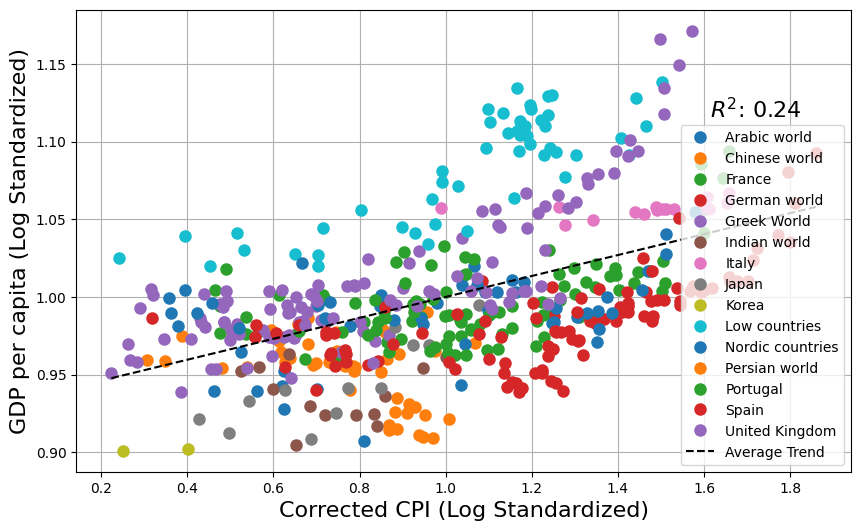

In [70]:
# Fitting an OLS model to obtain a single average trend line across all data
average_ols_model = smf.ols("log_gdp_std ~ N_est_log_std", data=df_ols).fit()

# Prepare plot for relationship with a single average trend line
plt.figure(figsize=(10, 6))
for name, group in df_ols.groupby('region_name'):
    plt.plot(group['N_est_log_std'], group['log_gdp_std'], marker='o', linestyle='', ms=8, label=name)

# Calculate the average trend line across all data
x_vals = np.linspace(df_ols['N_est_log_std'].min(), df_ols['N_est_log_std'].max(), 100)
y_vals = average_ols_model.params['Intercept'] + average_ols_model.params['N_est_log_std'] * x_vals
plt.plot(x_vals, y_vals, 'k--', label='Average Trend')

plt.legend()
plt.xlabel('Corrected CPI (Log Standardized)', fontsize=16)
plt.ylabel('GDP per capita (Log Standardized)', fontsize=16)
plt.title('')
plt.grid(True)

# Show R-squared on the plot for the average trend line
r_squared = average_ols_model.rsquared
plt.figtext(0.85, 0.7, f'$R^2$: {r_squared:.2f}', ha='right', fontsize=16)

plt.show()

### GDP per capita vs Corrected Index

In [71]:
models = {}

priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "N_est_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

corrected_index_fifty = bmb.Model(
    "log_gdp_std ~  N_est_log_std + (N_est_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)

corrected_index_fifty_fit = corrected_index_fifty.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.95,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~  N_est_log_std + (N_est_log_std|region_name)"] = corrected_index_fifty_fit

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_log_std, 1|region_name_sigma, 1|region_name_offset, N_est_log_std|region_name_sigma, N_est_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 106 seconds.


In [72]:
summary_table_50 = az.summary(corrected_index_fifty_fit)
summary_table_50 = summary_table_50[['mean', 'sd', 'hdi_3%','hdi_97%']]
summary_table_50.iloc[1]

mean       0.041
sd         0.016
hdi_3%     0.009
hdi_97%    0.070
Name: N_est_log_std, dtype: float64

### Visualization

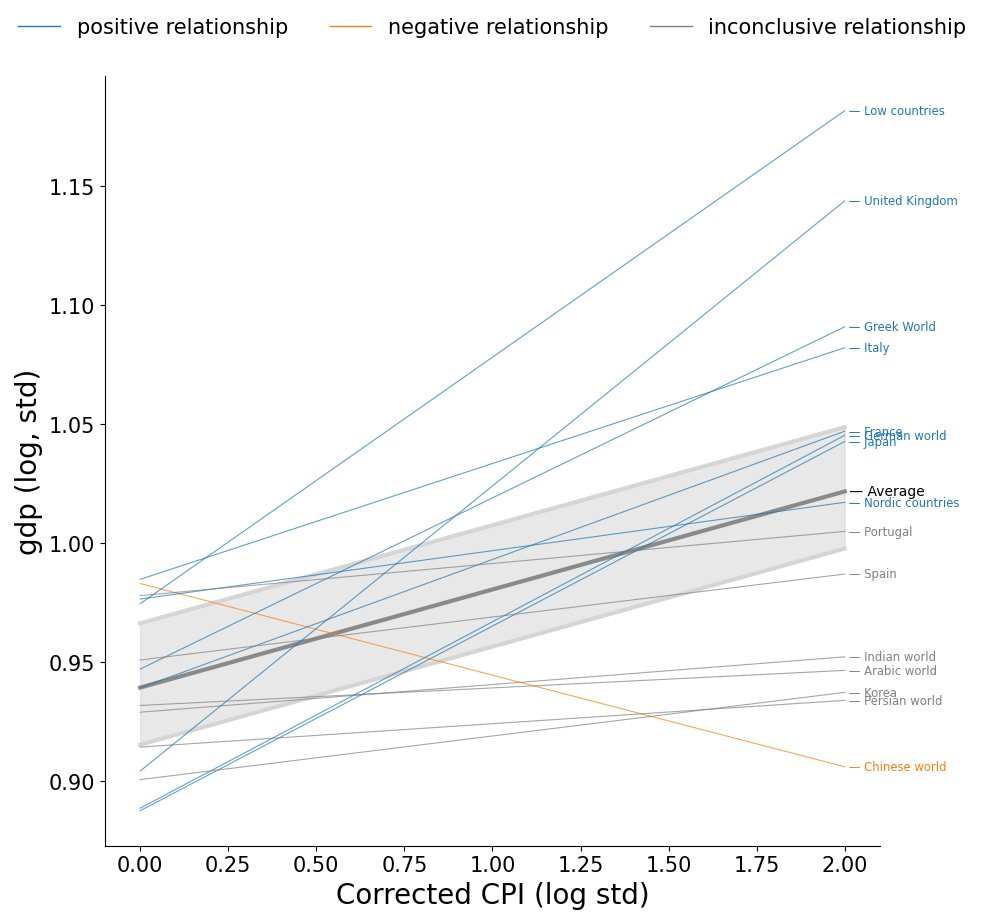

In [73]:
# NB: hitting max_treedepth is not much of a concern, at least not for model validity
# For more information about this and other warnings, see https://mc-stan.org/misc/warnings.html
# TODO, see if we can improve efficiency

posterior = az.extract(corrected_index_fifty_fit)

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import xarray as xr


intercept_common = posterior["Intercept"]
slope_common = posterior["N_est_log_std"]


score = np.array([0, 2])
score_xi = xr.DataArray(score)

fig, ax = plt.subplots(figsize=(10, 10))

ratio_li = az.summary(corrected_index_fifty_fit).loc['Intercept']['hdi_3%']/az.summary(corrected_index_fifty_fit).loc['Intercept']['mean']
ratio_ui = az.summary(corrected_index_fifty_fit).loc['Intercept']['hdi_97%']/az.summary(corrected_index_fifty_fit).loc['Intercept']['mean']

Y = (intercept_common + slope_common * score_xi)
Y_mean = Y.mean(axis=0)

Y_min = (intercept_common*ratio_li + slope_common * score_xi)
Y_min = Y_min.mean(axis=0)

Y_max = (intercept_common*ratio_ui + slope_common * score_xi)
Y_max = Y_max.mean(axis=0)


color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
        "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
        "grey")

ax.plot(score_xi, Y_mean, color=color, alpha=0.9, lw=3, label="Average")
ax.plot(score_xi, Y_min, color="lightgrey", alpha=0.9, lw=3, label="Average")
ax.plot(score_xi, Y_max, color="lightgrey", alpha=0.9, lw=3, label="Average")

# Plotting the confidence interval in light grey
ax.fill_between(score_xi, Y_min, Y_max, color='lightgrey', alpha=0.5)


ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + "Average",
        size="medium",
        color="black",
        ha="left",
        va="center",
    )

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["N_est_log_std|region_name"]


a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific


for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]

# Set the font sizes for ticks, labels, and legend
ax.tick_params(axis='both', labelsize=15)
ax.set_xlabel("Corrected CPI (log std)", fontsize=20)
ax.set_ylabel("GDP per capita (log, std)", fontsize=20)

custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False, fontsize=15)



#### Only Score

In [74]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "score_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

score_index_fifty = bmb.Model(
    "log_gdp_std ~  score_log_std + (score_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)

score_index_fifty_fit = score_index_fifty.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.95,
    idata_kwargs={"log_likelihood": True})


az.summary(score_index_fifty_fit)

# NB: hitting max_treedepth is not much of a concern, at least not for model validity
# For more information about this and other warnings, see https://mc-stan.org/misc/warnings.html
# TODO, see if we can improve efficiency


posterior = az.extract(score_index_fifty_fit)

models["log_gdp_std ~  score_log_std + (score_log_std|region_name)"] = score_index_fifty_fit

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_log_std, 1|region_name_sigma, 1|region_name_offset, score_log_std|region_name_sigma, score_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 100 seconds.


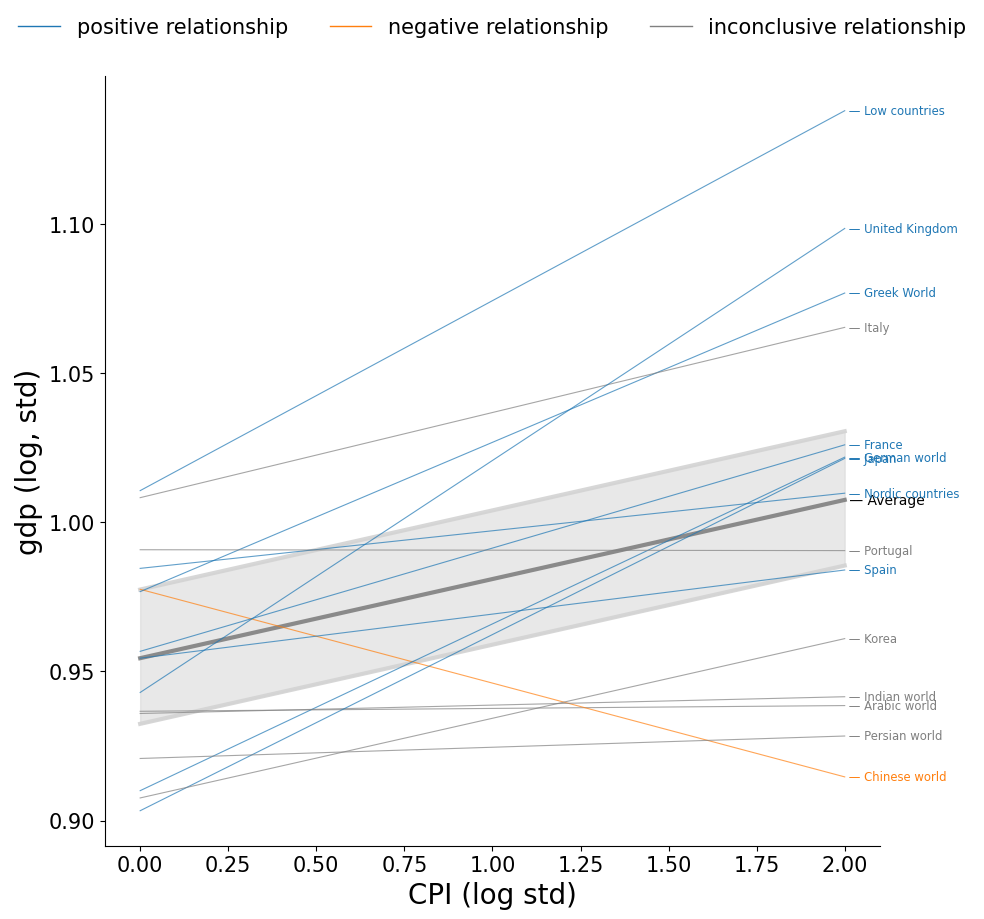

In [75]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import xarray as xr

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["score_log_std|region_name"]

intercept_common = posterior["Intercept"]
slope_common = posterior["score_log_std"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score = np.array([0, 2])
score_xi = xr.DataArray(score)

fig, ax = plt.subplots(figsize=(10, 10))


ratio_li = az.summary(score_index_fifty_fit).loc['Intercept']['hdi_3%']/az.summary(score_index_fifty_fit).loc['Intercept']['mean']
ratio_ui = az.summary(score_index_fifty_fit).loc['Intercept']['hdi_97%']/az.summary(score_index_fifty_fit).loc['Intercept']['mean']

Y = (intercept_common + slope_common * score_xi)
Y_mean = Y.mean(axis=0)

Y_min = (intercept_common*ratio_li + slope_common * score_xi)
Y_min = Y_min.mean(axis=0)

Y_max = (intercept_common*ratio_ui + slope_common * score_xi)
Y_max = Y_max.mean(axis=0)

color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
        "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
        "grey")

ax.plot(score_xi, Y_mean, color=color, alpha=0.9, lw=3, label="Average")
ax.plot(score_xi, Y_min, color="lightgrey", alpha=0.9, lw=3, label="Average")
ax.plot(score_xi, Y_max, color="lightgrey", alpha=0.9, lw=3, label="Average")

# Plotting the confidence interval in light grey
ax.fill_between(score_xi, Y_min, Y_max, color='lightgrey', alpha=0.5)
ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + "Average",
        size="medium",
        color="black",
        ha="left",
        va="center",
    )


for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]


# Set the font sizes for ticks, labels, and legend
ax.tick_params(axis='both', labelsize=15)
ax.set_xlabel("CPI (log std)", fontsize=20)
ax.set_ylabel("GDP per capita (log, std)", fontsize=20)

custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False, fontsize=15)




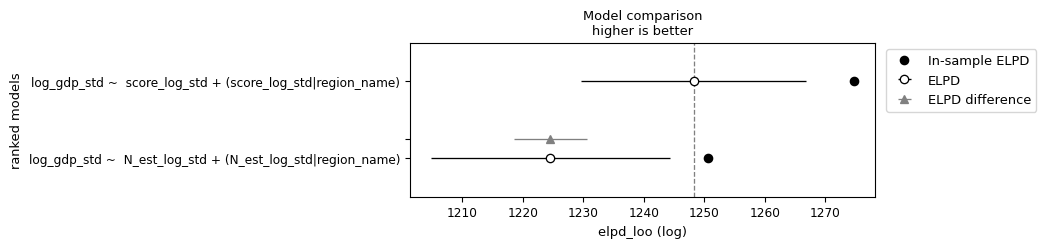

In [76]:
waic_compare = az.compare(models, ic='LOO')
az.plot_compare(waic_compare, insample_dev=True);

In [77]:
# az.summary(score_index_fifty_fit)

## For the modern period (1800-1880)

In [78]:
df_gdp = pd.read_csv("other_data/gdp_weighted_pop_decade.csv")
df_gdp = df_gdp.rename(columns={"region": "region_name"})

df_cultura = pd.read_csv("unseen_species_model/unseen_species_model_bayesian.csv", index_col = [0])
df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})
df_cultura['survival_ratio'] = df_cultura['score']/df_cultura['N_est']

# Add indiviudals not taken into account into the unseen-species model
df_works = pd.read_csv('db_extract/df_indi__work>2.csv', index_col=[0])
df_works = df_works.groupby(['decade', 'region_name'])['individual_wikidata_id'].count().reset_index()
df_works = df_works.rename(columns = {'individual_wikidata_id':'f>3'})

df_cultura = pd.merge(df_cultura, df_works, on = ['region_name', 'decade'], how='left')
df_cultura = df_cultura.fillna(0)
df_cultura['N_est'] = df_cultura['N_est'] + df_cultura['f>3']

df = pd.merge(df_gdp, df_cultura, on = ['region_name', 'decade'])
df = df.rename(columns = {'decade': 'year', 'gdp_pc_weighted':'gdp_per_capita'})
df['score_cap'] = df['score']/df['pop']
df['N_est_cap'] = df['N_est']/df['pop']

df = df[df['year']>=1800]

list(set(df.region_name))
df.region_name.value_counts()

keep = ['Indian world',
 'Nordic countries',
 'Persian world',
 'Portugal',
 'United Kingdom',
 'France',
 'Greek World',
 'Arabic world',
 'Chinese world',
 'Japan',
 'German world',
 'Low countries',
 'Italy',
 'Korea',
 'Spain']

# Apply normalization

df["century"] = df["year"].round(-2)
df["score_log"] = np.log(df["score"])
df["score_cap_log"] = np.log(df["score_cap"])

df["N_est_log"] = np.log(df["N_est"])
df["N_est_cap_log"] = np.log(df["N_est_cap"])
df["score_log_std"] = df["score_log"] / df["score_log"].mean()
df["score_cap_log_std"] = np.log(df["score_cap"]) / df["score_cap_log"].mean()

df["N_est_std"] = df["N_est"] / df["N_est"].mean()
df["N_est_log_std"] = df["N_est_log"] / df["N_est_log"].mean()

df["N_est_cap_log_std"] = np.log(df["N_est_cap"]) / df["N_est_cap_log"].mean()
df["log_gdp"] = np.log(df["gdp_per_capita"])

df["log_gdp_std"] = df["log_gdp"] / df["log_gdp"].mean()
df["gdp_std"] = df["gdp_per_capita"] / df["gdp_per_capita"].mean()
df["survival_ratio_std"] = df["survival_ratio"] / df["survival_ratio"].mean()

df.sample(5)

,region_name,year,gdp_per_capita,pop,N_est,score,survival_ratio,f>3,score_cap,N_est_cap,...,N_est_cap_log,score_log_std,score_cap_log_std,N_est_std,N_est_log_std,N_est_cap_log_std,log_gdp,log_gdp_std,gdp_std,survival_ratio_std
505,United Kingdom,1860,5028.818182,28901.909091,15713.038693,1144,0.073902,233.0,0.039582,0.543668,...,-0.609417,1.395452,0.686948,1.311242,1.215110,0.339337,8.522940,1.129393,2.351266,1.207683
149,German world,1840,2160.207251,28795.250000,79354.510007,2571,0.032497,240.0,0.089286,2.755819,...,1.013715,1.555909,0.513910,6.622080,1.418768,-0.564459,7.677959,1.017423,1.010023,0.531062
292,Low countries,1810,3267.107843,2549.168750,2192.099661,159,0.073744,36.0,0.062373,0.859927,...,-0.150907,1.004420,0.590212,0.182929,0.967412,0.084029,8.091660,1.072244,1.527564,1.205112
299,Low countries,1880,4635.759819,4794.363636,12211.348090,676,0.055760,88.0,0.140999,2.547022,...,0.934925,1.291205,0.416716,1.019029,1.183403,-0.520587,8.441555,1.118609,2.167489,0.911220
198,Greek World,1820,1947.323243,18490.487179,306.874182,17,0.055944,3.0,0.000919,0.016596,...,-4.098574,0.561410,1.487284,0.025608,0.720149,2.282177,7.574211,1.003675,0.910487,0.914227


### For corrected index

In [79]:
# models = {}

priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "N_est_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

corrected_index_decade = bmb.Model(
    "log_gdp_std ~  N_est_log_std + (N_est_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)

corrected_index_decade_fit = corrected_index_decade.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.95,
    idata_kwargs={"log_likelihood": True})


models["log_gdp_std ~  N_est_log_std + (N_est_log_std|region_name) (1800-1880)"] = corrected_index_decade_fit

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_log_std, 1|region_name_sigma, 1|region_name_offset, N_est_log_std|region_name_sigma, N_est_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 107 seconds.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.


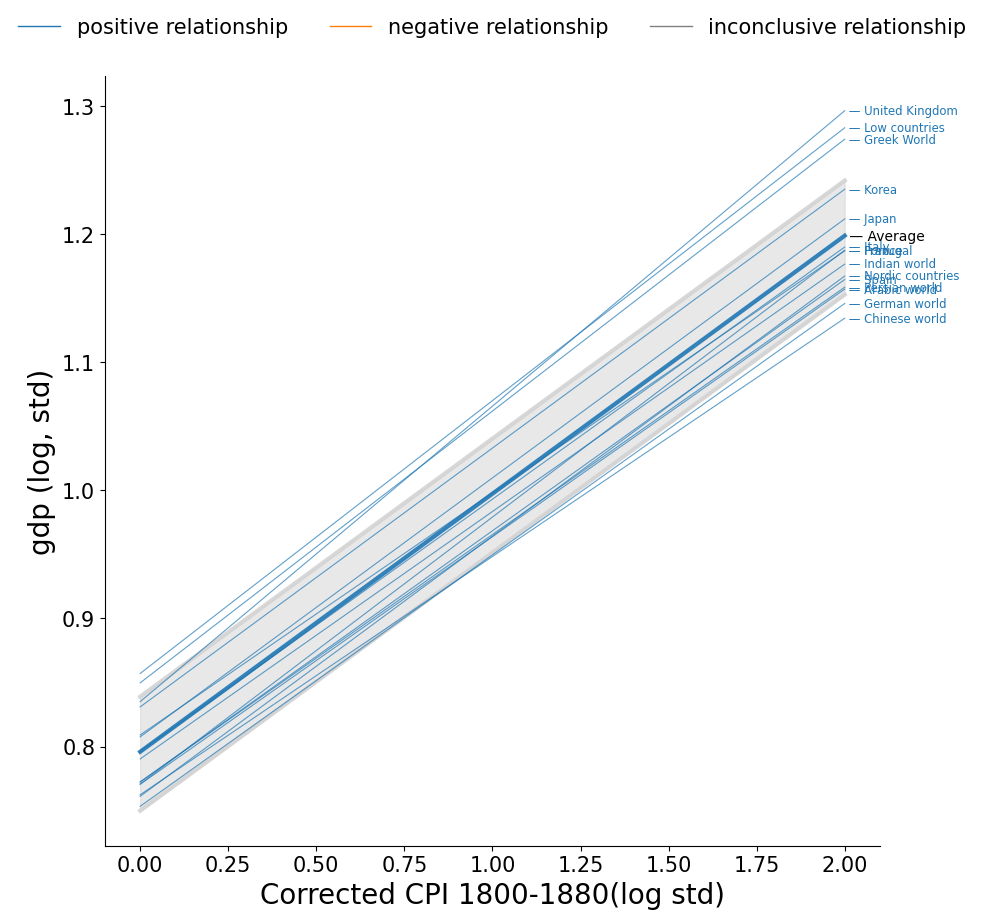

In [80]:

# NB: hitting max_treedepth is not much of a concern, at least not for model validity
# For more information about this and other warnings, see https://mc-stan.org/misc/warnings.html
# TODO, see if we can improve efficiency

posterior = az.extract(corrected_index_decade_fit)

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import xarray as xr


intercept_common = posterior["Intercept"]
slope_common = posterior["N_est_log_std"]


score = np.array([0, 2])
score_xi = xr.DataArray(score)

fig, ax = plt.subplots(figsize=(10, 10))

ratio_li = az.summary(corrected_index_decade_fit).loc['Intercept']['hdi_3%']/az.summary(corrected_index_decade_fit).loc['Intercept']['mean']
ratio_ui = az.summary(corrected_index_decade_fit).loc['Intercept']['hdi_97%']/az.summary(corrected_index_decade_fit).loc['Intercept']['mean']

Y = (intercept_common + slope_common * score_xi)
Y_mean = Y.mean(axis=0)

Y_min = (intercept_common*ratio_li + slope_common * score_xi)
Y_min = Y_min.mean(axis=0)

Y_max = (intercept_common*ratio_ui + slope_common * score_xi)
Y_max = Y_max.mean(axis=0)


color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
        "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
        "grey")

ax.plot(score_xi, Y_mean, color=color, alpha=0.9, lw=3, label="Average")
ax.plot(score_xi, Y_min, color="lightgrey", alpha=0.9, lw=3, label="Average")
ax.plot(score_xi, Y_max, color="lightgrey", alpha=0.9, lw=3, label="Average")

# Plotting the confidence interval in light grey
ax.fill_between(score_xi, Y_min, Y_max, color='lightgrey', alpha=0.5)


ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + "Average",
        size="medium",
        color="black",
        ha="left",
        va="center",
    )

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["N_est_log_std|region_name"]


a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific


for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
# Set the font sizes for ticks, labels, and legend
ax.tick_params(axis='both', labelsize=15)

ax.set_xlabel("Corrected CPI 1800-1880 (log std)", fontsize=20)
ax.set_ylabel("GDP per capita (log, std)", fontsize=20)

custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False, fontsize=15)


#### Score for modern period

In [81]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "N_est_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

score_index_decade = bmb.Model(
    "log_gdp_std ~  score_log_std + (score_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)

score_index_decade_fit = score_index_decade.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.95,
    idata_kwargs={"log_likelihood": True})


models["log_gdp_std ~  score_log_std + (score_log_std|region_name) (1800-1880)"] = score_index_decade_fit

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_log_std, 1|region_name_sigma, 1|region_name_offset, score_log_std|region_name_sigma, score_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 156 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


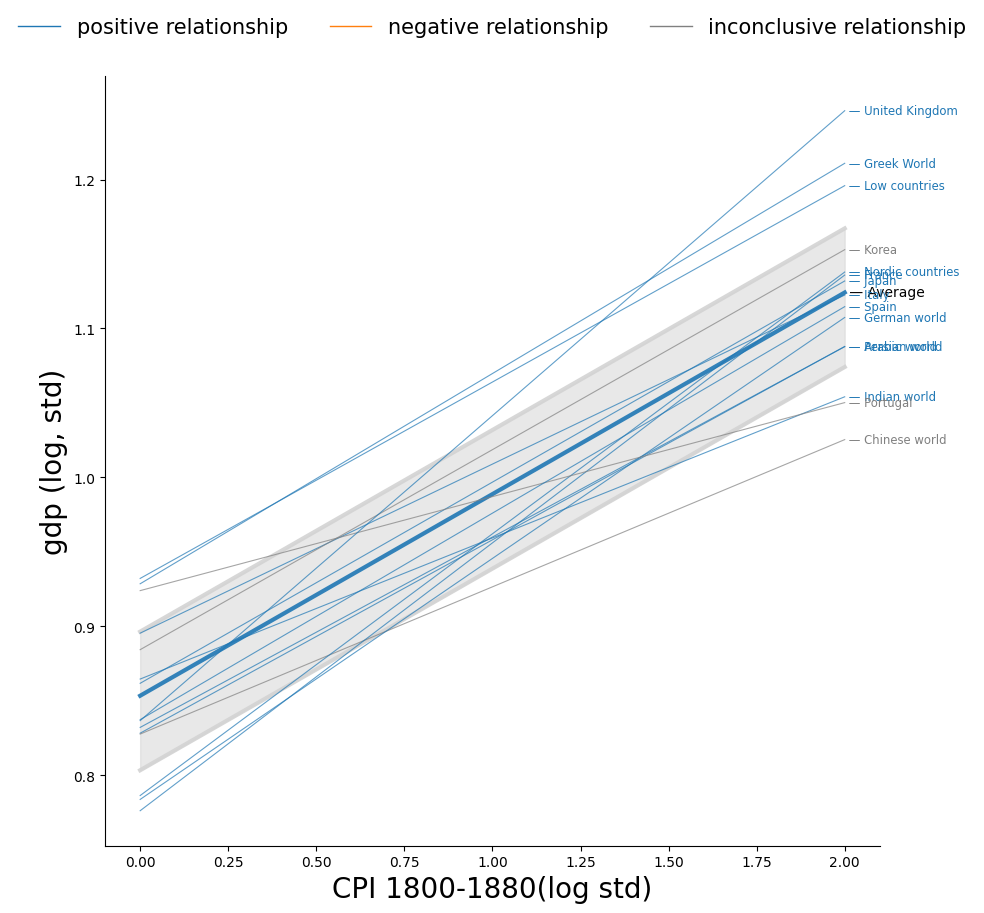

In [82]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import xarray as xr


posterior = az.extract(score_index_decade_fit)

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["score_log_std|region_name"]

intercept_common = posterior["Intercept"]
slope_common = posterior["score_log_std"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score = np.array([0, 2])
score_xi = xr.DataArray(score)

fig, ax = plt.subplots(figsize=(10, 10))


ratio_li = az.summary(score_index_decade_fit).loc['Intercept']['hdi_3%']/az.summary(score_index_decade_fit).loc['Intercept']['mean']
ratio_ui = az.summary(score_index_decade_fit).loc['Intercept']['hdi_97%']/az.summary(score_index_decade_fit).loc['Intercept']['mean']

Y = (intercept_common + slope_common * score_xi)
Y_mean = Y.mean(axis=0)

Y_min = (intercept_common*ratio_li + slope_common * score_xi)
Y_min = Y_min.mean(axis=0)

Y_max = (intercept_common*ratio_ui + slope_common * score_xi)
Y_max = Y_max.mean(axis=0)

color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
        "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
        "grey")

ax.plot(score_xi, Y_mean, color=color, alpha=0.9, lw=3, label="Average")
ax.plot(score_xi, Y_min, color="lightgrey", alpha=0.9, lw=3, label="Average")
ax.plot(score_xi, Y_max, color="lightgrey", alpha=0.9, lw=3, label="Average")

# Plotting the confidence interval in light grey
ax.fill_between(score_xi, Y_min, Y_max, color='lightgrey', alpha=0.5)
ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + "Average",
        size="medium",
        color="black",
        ha="left",
        va="center",
    )


for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.set_xlabel("CPI 1800-1880 (log std)", fontsize=20)
ax.set_ylabel("GDP per capita (log, std)", fontsize=20)

custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False, fontsize=15)


#### Model Comparison

In [83]:
models_fifty = {}
models_fifty["log_gdp_std ~  N_log_std + (N_log_std|region_name)"] = corrected_index_fifty_fit
models_fifty["log_gdp_std ~  score_log_std + (score_log_std|region_name)"] = score_index_fifty_fit

models_decade = {}
models_decade["log_gdp_std ~  N_log_std + (N_log_std|region_name) (1800-1880)"] = corrected_index_decade_fit
models_decade["log_gdp_std ~  score_log_std + (score_log_std|region_name) (1800-1880)"] = score_index_decade_fit

/home/charles/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:805: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


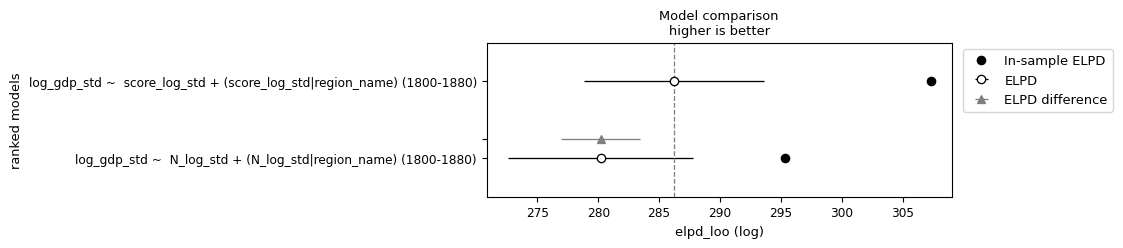

In [84]:
waic_compare = az.compare(models_decade, ic='LOO')
az.plot_compare(waic_compare, insample_dev=True);

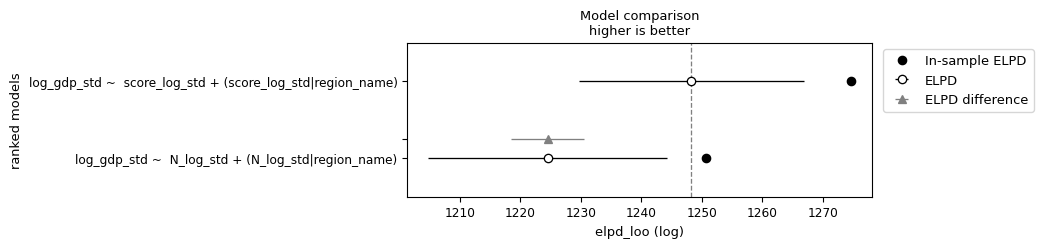

In [85]:
waic_compare = az.compare(models_fifty, ic='LOO')
az.plot_compare(waic_compare, insample_dev=True);

### Make table

In [86]:
def make_table(corrected_index_fifty_fit, name = 'corrected_index_fifty_fit'):

    summary_table_50 = az.summary(corrected_index_fifty_fit)
    #summary_table_50 = summary_table_50[['mean', 'sd', 'hdi_3%','hdi_97%']]
    summary_table_50 = summary_table_50.iloc[1]

In [87]:
def make_table(corrected_index_fifty_fit, name="N_est_log_std"):


    summary_table_50 = az.summary(corrected_index_fifty_fit)
    #summary_table_50 = summary_table_50[['mean', 'sd', 'hdi_3%','hdi_97%']]
    summary_table_50 = summary_table_50.iloc[1]
    summary_table_50 = summary_table_50.reset_index()
    summary_table_50 = summary_table_50.set_index('index')
    summary_table_50.index.name = ""
    summary_table_50.columns = [name]

    return summary_table_50




table_1 = make_table(corrected_index_fifty_fit, name="N_est_log_std")
table_2 = make_table(score_index_fifty_fit, name="score_log_std")
table_3 = make_table(corrected_index_decade_fit, name="N_est_log_std (1800-1880)")
table_4 = make_table(score_index_decade_fit, name="score_log_std (1800-1880")


final_table = pd.concat([table_1, table_2, table_3, table_4], axis=1)

final_table = final_table[[ 'score_log_std',
                           'N_est_log_std',
 'score_log_std (1800-1880',
 'N_est_log_std (1800-1880)']]

final_table.columns = ['CPI vs GPD per capita', 'CPI Corrected vs GPD per capita', 'CPI (1800-1880) vs GPD per capita', 'CPI Corrected (1800-1880) vs GPD per capita']

In [88]:
final_table

,CPI vs GPD per capita,CPI Corrected vs GPD per capita,CPI (1800-1880) vs GPD per capita,CPI Corrected (1800-1880) vs GPD per capita
,,,,
mean,0.027,0.041,0.135,0.201
sd,0.012,0.016,0.023,0.024
hdi_3%,0.004,0.009,0.092,0.158
hdi_97%,0.049,0.070,0.181,0.246
mcse_mean,0.000,0.000,0.000,0.000
mcse_sd,0.000,0.000,0.000,0.000
ess_bulk,2195.000,1959.000,3914.000,5098.000
ess_tail,3385.000,3065.000,2882.000,4589.000
r_hat,1.000,1.000,1.000,1.000


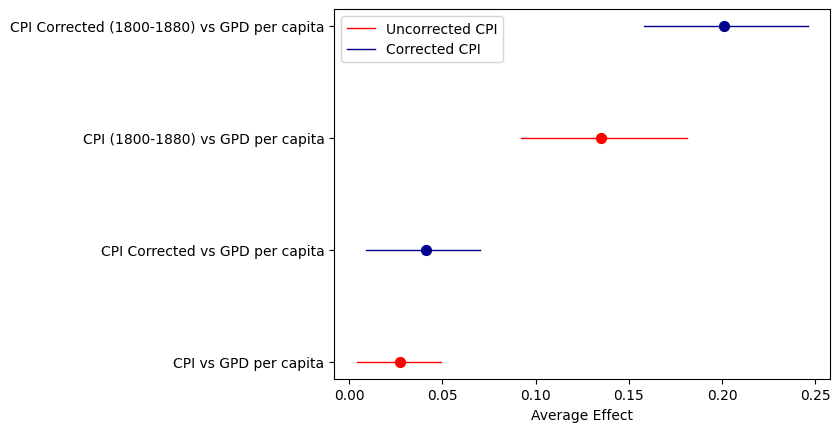

In [89]:
# Adjusting the plot to ensure all HDI lines have the same thickness

fig, ax = plt.subplots()



# Colors and labels for different model types
colors = ['darkblue' if 'Corrected' in model else 'red' for model in final_table.columns]
labels = ['Corrected CPI' if 'Corrected' in model else 'Uncorrected CPI' for model in final_table.columns]
used_labels = set()

# Plotting each model with their respective color and consistent HDI line thickness
for i, model in enumerate(final_table.columns):
    label = labels[i] if labels[i] not in used_labels else ""
    ax.plot([final_table.loc["hdi_3%", model], final_table.loc["hdi_97%", model]], [i, i],
            color=colors[i],  markersize=10, linewidth=1, label=label)  # Consistent HDI line thickness
    ax.scatter(final_table.loc["mean", model], i, color=colors[i], s=50)  # Mean scatter
    used_labels.add(labels[i])

ax.set_yticks(range(len(final_table.columns)))
ax.set_yticklabels(final_table.columns)
ax.set_xlabel('Average Effect')
ax.set_title('')

# Adding a legend to the plot
ax.legend()

#plt.tight_layout()
plt.show()


### Make a graph of the different alphas